<a href="https://colab.research.google.com/github/sakshimohta/fake_news_detection/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 36.8 MB/s 
     |████████████████████████████████| 182 kB 69.5 MB/s 
     |████████████████████████████████| 7.6 MB 58.8 MB/s 


In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import indian
nltk.download('indian')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
import re
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Unzipping corpora/indian.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/news_dataset.csv')

In [ ]:
df = df.dropna()

In [ ]:
df.head()

,label,text
0,REAL,Payal has accused filmmaker Anurag Kashyap of ...
1,FAKE,A four-minute-long video of a woman criticisin...
2,FAKE,"Republic Poll, a fake Twitter account imitatin..."
3,REAL,"Delhi teen finds place on UN green list, turns..."
4,REAL,Delhi: A high-level meeting underway at reside...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3721 entries, 0 to 3728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3721 non-null   object
 1   text    3721 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


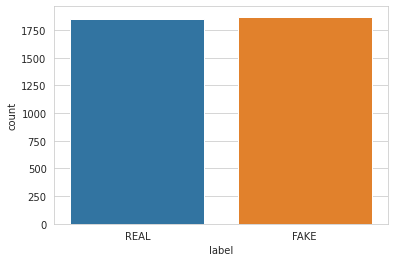

In [ ]:
label = df['label']
sns.set_style('whitegrid')
sns.countplot(label)

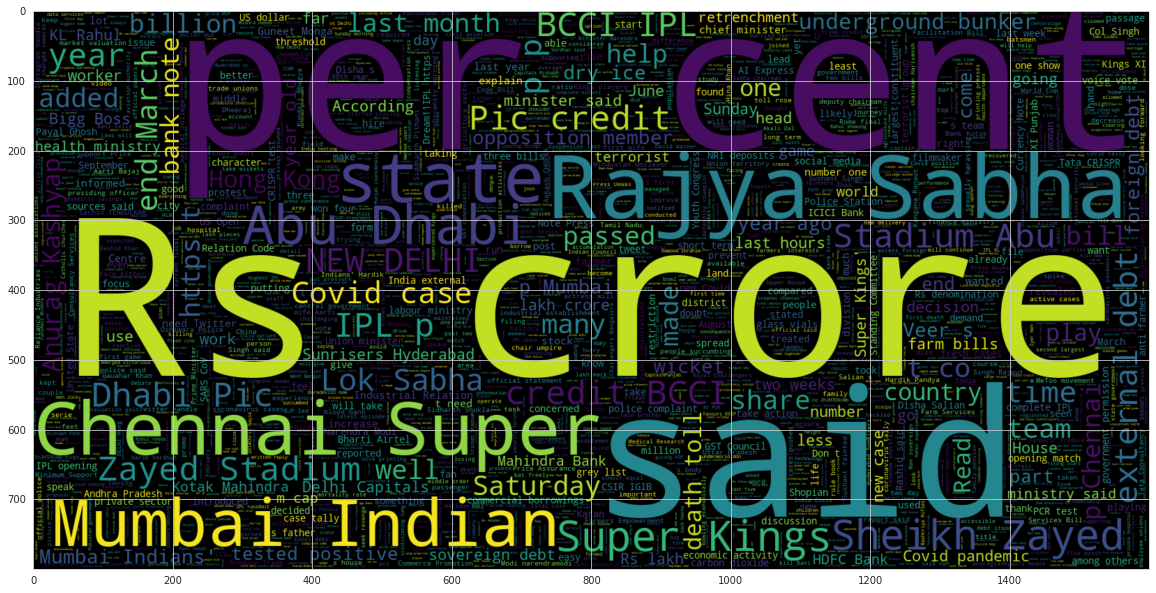

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 'REAL'].text))
plt.imshow(wc, interpolation = 'bilinear')

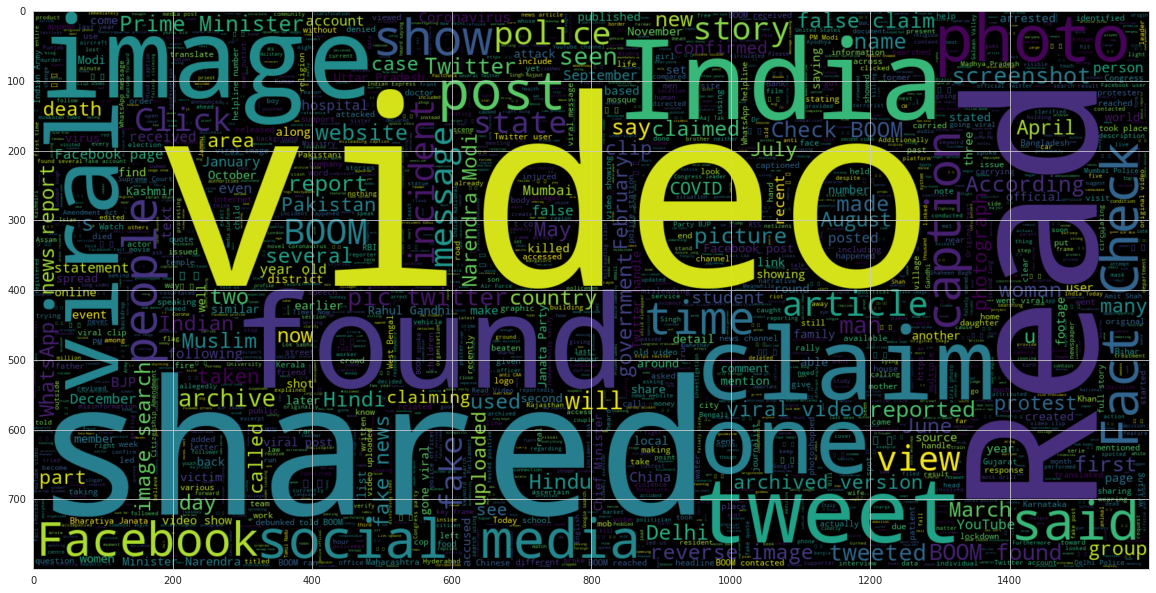

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 'FAKE'].text))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
df.label = pd.Categorical(df.label)

In [ ]:
df['label'] = df.label.cat.codes

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df = df.drop(['index'],axis=1)

In [ ]:
def clean_text(text):
  text = text.lower()
  text = text.strip()
  text = re.sub('\n','',text)
  text = re.sub('\'','',text)
  text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text)
  text = re.sub('|','',text)
  text = re.sub('/','',text)
  text = re.sub('`','',text)
  text = re.sub('"','',text)
  text = re.sub("'",'',text)
  text = re.sub('!','',text)
  text = re.sub(',','',text)
  text = re.sub(':','',text)
  text = re.sub(r"[\([{})\]]", "", text)
  text = re.sub('<','',text)
  text = re.sub('>','',text)
  text = re.sub('-',' ',text)
  text = text.replace('?','')
  text = text.replace('*','')
  text = text.replace('|',' ')
  return text

In [ ]:
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in (set(stopwords.words('english')) or set(nltk.corpus.indian.words('hindi.pos'))):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

In [ ]:
def cleaning(text):
  text = clean_text(text)
  text = remove_stopwords_and_lemmatization(text)
  return text

In [ ]:
df['text'] = df['text'].apply(cleaning)

In [ ]:
max_len=128
data_text=df["text"]
data_label=df["label"]

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state = 42,shuffle=True)

In [ ]:
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 128,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'np',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [ ]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [ ]:
maxlen = 128

In [ ]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

In [ ]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

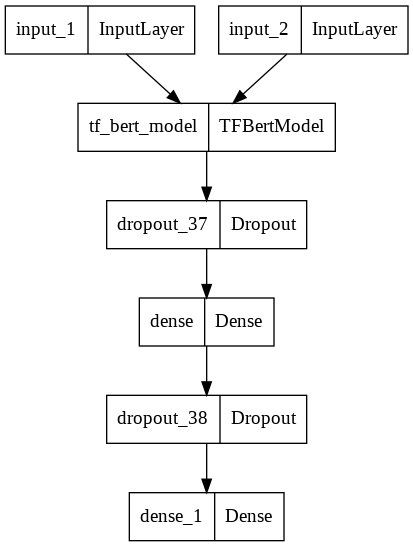

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
history = model.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train, epochs=5, validation_split = 0.2, batch_size = 32)

Epoch 1/5
75/75 [==============================] - 88s 898ms/step - loss: 0.3800 - accuracy: 0.8282 - val_loss: 0.0541 - val_accuracy: 0.9832
Epoch 2/5
75/75 [==============================] - 68s 908ms/step - loss: 0.0397 - accuracy: 0.9916 - val_loss: 0.0499 - val_accuracy: 0.9866
Epoch 3/5
75/75 [==============================] - 67s 899ms/step - loss: 0.0197 - accuracy: 0.9954 - val_loss: 0.0239 - val_accuracy: 0.9950
Epoch 4/5
75/75 [==============================] - 67s 897ms/step - loss: 0.0123 - accuracy: 0.9979 - val_loss: 0.0262 - val_accuracy: 0.9950
Epoch 5/5
75/75 [==============================] - 67s 900ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.0297 - val_accuracy: 0.9933


In [ ]:
import pickle

In [ ]:
filename = 'bert.pkl'
pickle.dump(model,open(filename,'wb'))

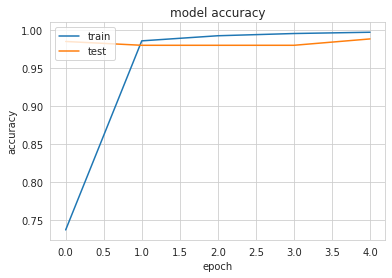

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

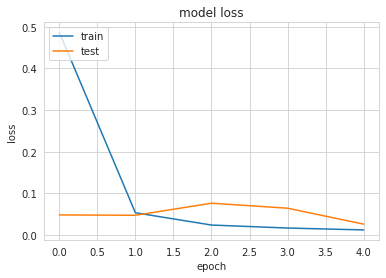

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

24/24 [==============================] - 9s 256ms/step


In [ ]:
y_pred.shape

(745, 1)

In [ ]:
accuracy_score(y_pred,Y_test)

0.9946308724832215

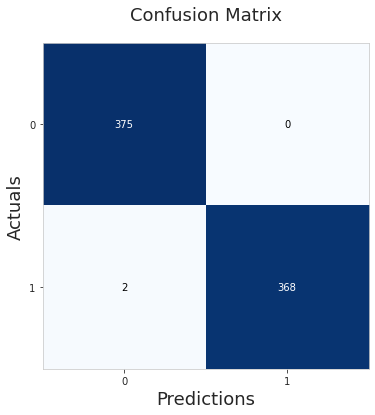

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       375
           1       1.00      0.99      1.00       370

    accuracy                           1.00       745
   macro avg       1.00      1.00      1.00       745
weighted avg       1.00      1.00      1.00       745



In [ ]:
test_text = 'मध्यप्रदेश के कूनो नेशनल पार्क के बड़े बाड़े में छोडे़ जाने के बाद अफ्रीकी चीतों ने खुद पहली बार शिकार किया। दोनों चीतों ने करीब 48 घंटे बाद एक चीतल का शिकार किया। कूनो नेशनल पार्क प्रबंधन ने सोमवार को इसकी जानकारी दी। पार्क प्रबंधन ने बताया कि दोनों चीते स्वस्थ हैं। वे बड़े बाड़े में घूम रहे हैं। डीएफओ प्रकाश वर्मा ने बताया कि कॉलर आईडी, सीसीटीवी और ट्रैप कैमरों से टीम लगातार उन पर नजर रख रही है। अफ्रीका के नामीबिया से 17 सितंबर को 8 चीते कूनो नेशनल पार्क लाए गए थे। PM नरेंद्र मोदी ने इन्हें छोटे बाड़े में छोड़ा था। यहां चीतों को क्वारंटाइन किया गया था। इसके करीब 50 दिन बाद शनिवार को दो नर चीतों को बड़े बाड़े में छोड़ा गया था। दोनों चीतों को बड़े बाड़े में छोड़ने से पहले चीता टास्क फोर्स की बैठक हुई। टास्क फोर्स के सदस्यों की सहमति के बाद चीतों को छोड़ा गया था। खुद पेट भर सकेंगे चीते डीएफओ वर्मा ने बताया कि, लंबे अरसे के बाद देश की धरती पर लाए गए चीतों ने पहली बार शिकार किया है। अब वह खुद पसंदीदा जानवर का शिकार करके खुद अपना पेट भर सकेंगे। छह अन्य चीतों को रिलीज करने का निर्णय चीता टास्क फोर्स करेगा। हमारी तैयारियां पूरी हैं। यह भी पढ़ें कूनो में दो बड़े बाड़े में छोड़ा, पीएम मोदी बोले -ग्रेट न्यूज'

In [ ]:
test_token = tokenize(test_text)

In [ ]:
test_text_pred = np.where(model.predict({ 'input_1' : test_token['input_ids'] , 'input_2' : test_token['attention_mask']}) >=0.5,1,0)

35/35 [==============================] - 9s 260ms/step


In [ ]:
if(test_text_pred[0]==0):
    print("News is Fake")
else:
    print("News is Real")

News is Real


In [ ]:
!pip install git+https://github.com/marcotcr/lime.git

In [ ]:
import lime
from lime.lime_text import LimeTextExplainer

In [ ]:
import torch

In [ ]:
class_names = ['True','Fake']

In [ ]:
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
test1 = X_test[624]

In [ ]:
test1_token = tokenize(test1)

In [ ]:
def predict_probab(STR):
    z = bert_tokenizer.encode_plus(STR, add_special_tokens = True, max_length = 128, truncation = True,padding = 'max_length', return_token_type_ids=False, return_attention_mask = True,  return_tensors = 'np')
    inputs = [z['input_ids'], z['attention_mask']]
    k = []
    k.append(float(model.predict(inputs).reshape(-1,1)))
    k.append(float(1-model.predict(inputs).reshape(-1,1)))
    k = np.array(k).reshape(1,-1)

    return k

In [ ]:
exp = explainer.explain_instance(test1,predict_probab,num_features=100,num_samples=1)

1/1 [==============================] - 0s 81ms/step


In [ ]:
exp.show_in_notebook(text=test1)